## Import
The following code imports the necessary code to run the code in the rest of this Colaboratory.

In [99]:
import os,sys
from google.colab import files, drive
import zipfile
import random
import shutil
from shutil import copyfile

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np

import PIL
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import sklearn
from sklearn.datasets import load_files
from sklearn.metrics import classification_report

In [100]:
print(tf.__version__)

2.12.0


## Hubungkan google colab dengan google drive untuk mengambil data


In [101]:
import os
import gdown
import zipfile

data_dir = './ds_buah'

# Create the "download" directory if it doesn't exist
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

# Define the Google Drive file IDs
file_ids = {
    'raw_apple': '1RcFgea5MqvqoOdYiOTERezE348GYNyqn',
    'ripe_apple': '1pElNpsrYoLSOwsGDRpJJoWzkLJyz2CA3'
}

# Download and extract the files
for file_name, file_id in file_ids.items():
    file_path = os.path.join(data_dir, f'{file_name}.zip')
    gdown.download(f'https://drive.google.com/uc?id={file_id}', file_path, quiet=False)

    # Extract the contents of the zip file
    extract_dir = os.path.join(data_dir, file_name)
    with zipfile.ZipFile(file_path, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)

    print(f'Successfully downloaded and extracted {file_name} data.')


Downloading...
From: https://drive.google.com/uc?id=1RcFgea5MqvqoOdYiOTERezE348GYNyqn
To: /content/ds_buah/raw_apple.zip
100%|██████████| 133M/133M [00:00<00:00, 198MB/s]


Successfully downloaded and extracted raw_apple data.


Downloading...
From: https://drive.google.com/uc?id=1pElNpsrYoLSOwsGDRpJJoWzkLJyz2CA3
To: /content/ds_buah/ripe_apple.zip
100%|██████████| 21.7M/21.7M [00:00<00:00, 191MB/s]


Successfully downloaded and extracted ripe_apple data.


**Ekstraksi**

In [102]:
batch_size = 32
img_height = 150
img_width = 150
data_dir="./ds_buah"

In [103]:
import os
import zipfile

data_dir = './ds_buah/'

# Membuat daftar file zip dalam direktori
zip_files = [item for item in os.listdir(data_dir) if item.endswith('.zip')]

# Ekstrak file zip satu per satu
for zip_file in zip_files:
    zip_path = os.path.join(data_dir, zip_file)
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(data_dir)

# Mendapatkan daftar buah setelah ekstraksi
buah = [item for item in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, item))]
buah.sort()
print(buah)

num_class = len(buah)


['raw_apple', 'ripe_apple']


Found 4800 files belonging to 2 classes.
Using 2400 files for training.
Found 4800 files belonging to 2 classes.
Using 2400 files for validation.


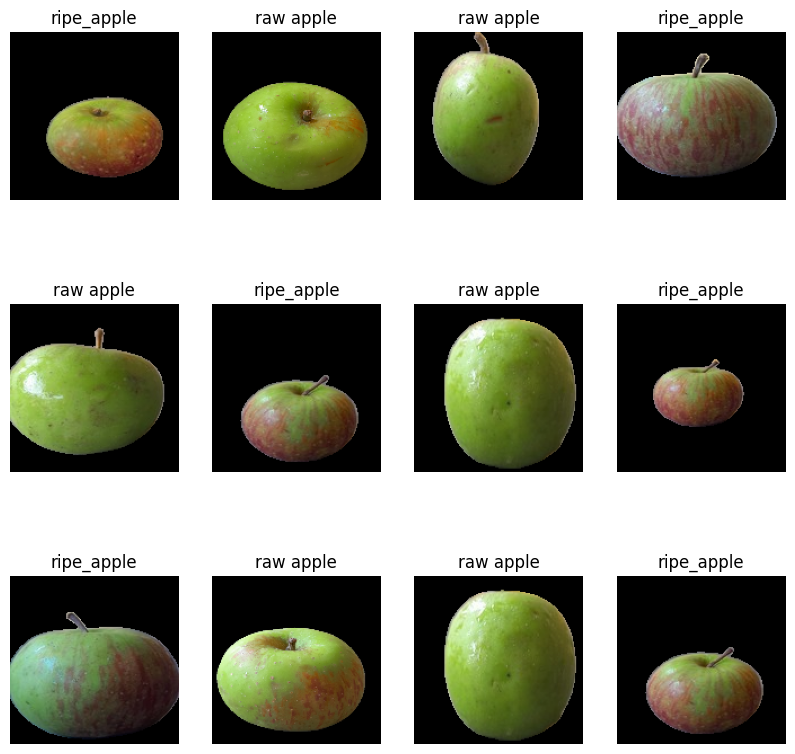

In [104]:
import matplotlib.pyplot as plt

train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.5,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    class_names=['raw_apple','ripe_apple']
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.5,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    class_names=['raw_apple','ripe_apple']
)


class_names = ["raw apple",'ripe_apple']

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(12):
    ax = plt.subplot(3, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [105]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 150, 150, 3)
(32,)


In [106]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal_and_vertical",
                             input_shape=(img_height,img_width,3)),
  tf.keras.layers.RandomRotation(0.4),
  tf.keras.layers.RandomContrast(0.5),
  tf.keras.layers.RandomBrightness(0.1)
])

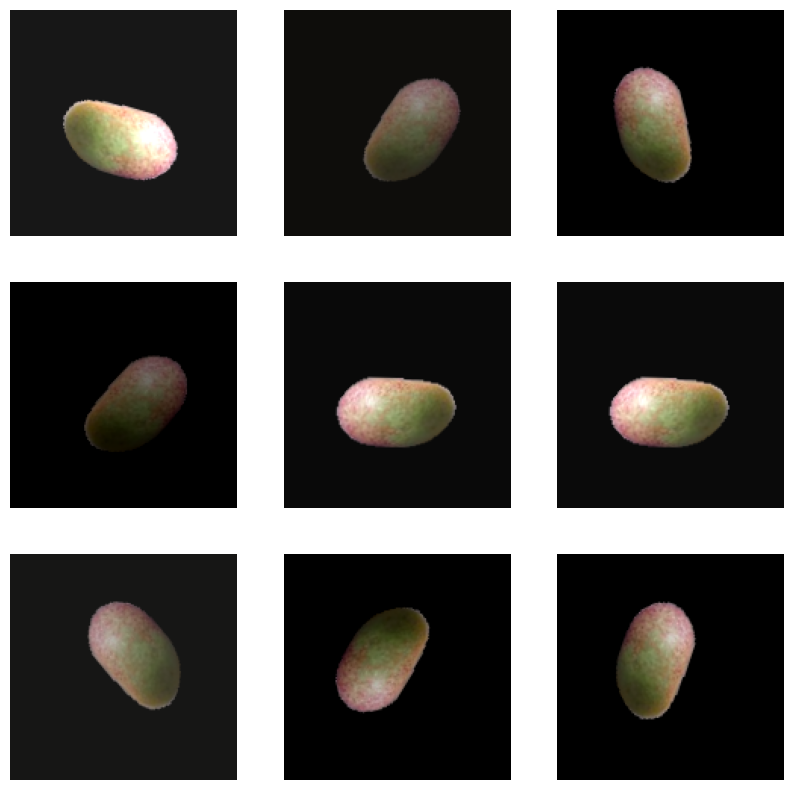

In [107]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [108]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Membuat objek ImageDataGenerator untuk augmentasi data
data_augmentation = ImageDataGenerator(
    rescale=1./255,
    rotation_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Pra-pemrosesan gambar pada dataset training
train_generator = data_augmentation.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    subset='training',
    class_mode='binary',
    seed=123
)

# Pra-pemrosesan gambar pada dataset validasi
val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    subset='validation',
    class_mode='binary',
    seed=123
)

Found 4800 images belonging to 2 classes.
Found 0 images belonging to 2 classes.


In [109]:
pip install tensorflow-model-optimization


## Model CNN dengan Sequential

In [110]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.2)
])

model = tf.keras.models.Sequential([
    data_augmentation,
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

initial_learning_rate = 1.0
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=1000, decay_rate=0.96, staircase=True
)
optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

EPOCHS = 20

train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.5,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    class_names=['raw_apple', 'ripe_apple']
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.5,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    class_names=['raw_apple', 'ripe_apple']
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    verbose=1
)

model.summary()

# Menyimpan model
model.save('model.h5')


Found 4800 files belonging to 2 classes.
Using 2400 files for training.
Found 4800 files belonging to 2 classes.
Using 2400 files for validation.
Epoch 1/20
75/75 [==============================] - 23s 270ms/step - loss: 0.4867 - accuracy: 0.9421 - val_loss: 1.2882 - val_accuracy: 0.6587
Epoch 2/20
75/75 [==============================] - 21s 270ms/step - loss: 0.1739 - accuracy: 0.9638 - val_loss: 0.5941 - val_accuracy: 0.8104
Epoch 3/20
75/75 [==============================] - 11s 135ms/step - loss: 0.1221 - accuracy: 0.9721 - val_loss: 0.9325 - val_accuracy: 0.7617
Epoch 4/20
75/75 [==============================] - 10s 131ms/step - loss: 0.1295 - accuracy: 0.9729 - val_loss: 0.1943 - val_accuracy: 0.9663
Epoch 5/20
75/75 [==============================] - 10s 121ms/step - loss: 0.1141 - accuracy: 0.9800 - val_loss: 1.9799 - val_accuracy: 0.6538
Epoch 6/20
75/75 [==============================] - 13s 165ms/step - loss: 0.1502 - accuracy: 0.9667 - val_loss: 0.0770 - val_accuracy: 0.9

75/75 [==============================] - 1s 9ms/step


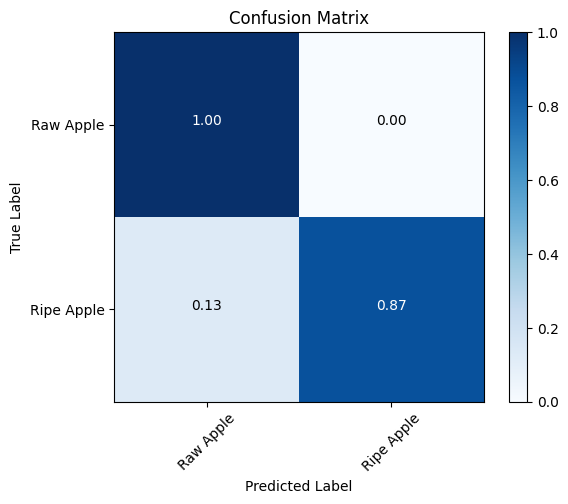

In [111]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Mengambil data dari validation dataset
x_val = []
y_val = []
for images, labels in val_ds:
    x_val.extend(images)
    y_val.extend(labels)

x_val = np.array(x_val)
y_val = np.array(y_val)

# Melakukan prediksi pada validation dataset
y_pred = model.predict(x_val)
y_pred_round = np.round(y_pred).flatten()  # Prediksi setelah dilakukan pembulatan

# Membuat confusion matrix
cm = confusion_matrix(y_val, y_pred_round)

# Normalisasi confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Menampilkan confusion matrix
class_names = ['Raw Apple', 'Ripe Apple']
plt.imshow(cm_normalized, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()
plt.xticks(np.arange(len(class_names)), class_names, rotation=45)
plt.yticks(np.arange(len(class_names)), class_names)

# Menampilkan akurasi dan nilai FP/FN untuk setiap kelas
for i in range(len(class_names)):
    for j in range(len(class_names)):
        plt.text(j, i, f'{cm_normalized[i, j]:.2f}', horizontalalignment="center",
                 color="white" if cm_normalized[i, j] > 0.5 else "black")

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


In [112]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

# Mengambil data dari validation dataset
x_val = []
y_val = []
for images, labels in val_ds:
    x_val.extend(images.numpy())
    y_val.extend(labels.numpy())

x_val = np.array(x_val)
y_val = np.array(y_val)

# Melakukan prediksi pada validation dataset
y_pred = model.predict(x_val)
y_pred = np.round(y_pred).flatten()

# Membuat mapping label
label_mapping = {0: 'raw_apple', 1: 'ripe_apple'}

# Mengubah label menjadi integer
y_val_int = np.array([label_mapping[label] for label in y_val])
y_pred_int = np.array([label_mapping[label] for label in y_pred])

# Menghitung precision, recall, dan F1 score untuk ripe apple
precision_ripe_apple = precision_score(y_val_int, y_pred_int, pos_label='ripe_apple')
recall_ripe_apple = recall_score(y_val_int, y_pred_int, pos_label='ripe_apple')
f1_score_ripe_apple = f1_score(y_val_int, y_pred_int, pos_label='ripe_apple')

# Menghitung precision, recall, dan F1 score untuk raw apple
precision_raw_apple = precision_score(y_val_int, y_pred_int, pos_label='raw_apple')
recall_raw_apple = recall_score(y_val_int, y_pred_int, pos_label='raw_apple')
f1_score_raw_apple = f1_score(y_val_int, y_pred_int, pos_label='raw_apple')

print("Ripe Apple:")
print("Precision:", precision_ripe_apple)
print("Recall:", recall_ripe_apple)
print("F1 Score:", f1_score_ripe_apple)

print("Raw Apple:")
print("Precision:", precision_raw_apple)
print("Recall:", recall_raw_apple)
print("F1 Score:", f1_score_raw_apple)


75/75 [==============================] - 1s 14ms/step
Ripe Apple:
Precision: 1.0
Recall: 0.8729096989966555
F1 Score: 0.932142857142857
Raw Apple:
Precision: 0.887905604719764
Recall: 1.0
F1 Score: 0.9406249999999999


In [113]:
import numpy as np
from sklearn.metrics import confusion_matrix

# Mengambil data dari validation dataset
x_val = []
y_val = []
for images, labels in val_ds:
    x_val.extend(images.numpy())
    y_val.extend(labels.numpy())

x_val = np.array(x_val)
y_val = np.array(y_val)

# Melakukan prediksi pada validation dataset
y_pred = model.predict(x_val)
y_pred = np.round(y_pred).flatten()

# Membuat mapping label
label_mapping = {0: 'raw_apple', 1: 'ripe_apple'}

# Mengubah label menjadi integer
y_val_int = np.array([label_mapping[label] for label in y_val])
y_pred_int = np.array([label_mapping[label] for label in y_pred])

# Membuat confusion matrix
cm = confusion_matrix(y_val_int, y_pred_int, labels=['ripe_apple', 'raw_apple'])

# Menampilkan hasil confusion matrix
print("Confusion Matrix:")
print(cm)

# Mendapatkan nilai True Positive (TP), True Negative (TN), False Positive (FP), dan False Negative (FN)
tp_ripe_apple = cm[0, 0]
tn_ripe_apple = cm[1, 1]
fp_ripe_apple = cm[1, 0]
fn_ripe_apple = cm[0, 1]

tp_raw_apple = cm[1, 1]
tn_raw_apple = cm[0, 0]
fp_raw_apple = cm[0, 1]
fn_raw_apple = cm[1, 0]

print("Ripe Apple:")
print("True Positive (TP):", tp_ripe_apple)
print("True Negative (TN):", tn_ripe_apple)
print("False Positive (FP):", fp_ripe_apple)
print("False Negative (FN):", fn_ripe_apple)

print("Raw Apple:")
print("True Positive (TP):", tp_raw_apple)
print("True Negative (TN):", tn_raw_apple)
print("False Positive (FP):", fp_raw_apple)
print("False Negative (FN):", fn_raw_apple)


75/75 [==============================] - 1s 12ms/step
Confusion Matrix:
[[1044  152]
 [   0 1204]]
Ripe Apple:
True Positive (TP): 1044
True Negative (TN): 1204
False Positive (FP): 0
False Negative (FN): 152
Raw Apple:
True Positive (TP): 1204
True Negative (TN): 1044
False Positive (FP): 152
False Negative (FN): 0


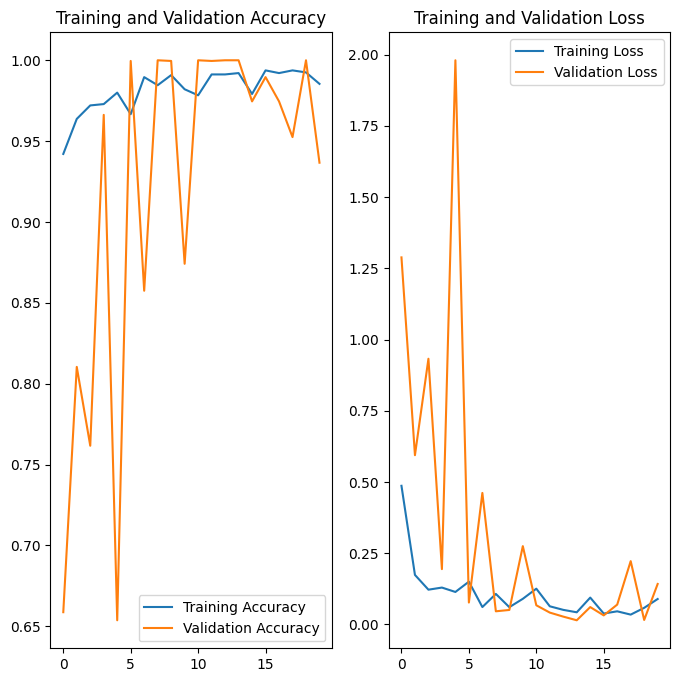

In [114]:
epochs = len(history.history['accuracy'])
epochs_range = range(epochs)

# Plotting accuracy
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, history.history['accuracy'], label='Training Accuracy')
plt.plot(epochs_range, history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Plotting loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, history.history['loss'], label='Training Loss')
plt.plot(epochs_range, history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()


In [115]:
from keras.preprocessing.image import ImageDataGenerator

print("Training Loss:", history.history['loss'][-1])
print("Training Accuracy:", history.history['accuracy'][-1])
print("Validation Loss:", history.history['val_loss'][-1])
print("Validation Accuracy:", history.history['val_accuracy'][-1])



Training Loss: 0.0894336849451065
Training Accuracy: 0.9854166507720947
Validation Loss: 0.14214761555194855
Validation Accuracy: 0.9366666674613953


In [2]:
# Menyimpan model ke dalam file H5
model.save('model.h5')


NameError: ignored

## Plot Loss and Accuracy

In [1]:
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import cv2

model_predict = tf.keras.models.load_model('model.h5')
model_predict.compile(optimizer='adam',
                      loss='binary_crossentropy',
                      metrics=['accuracy'])

# Make sure to import the 'files' module from the 'google.colab' package
from google.colab import files

# Allow the user to upload multiple images at once
uploaded = files.upload()

# Loop through the uploaded files and predict on each one
for fn in uploaded.keys():
  # Only try to load the file if it is an image
  if fn.endswith(('png', 'jpg', 'jpeg')):
    path = fn
    img = image.load_img(path, color_mode="rgb", target_size=(150, 150), interpolation="nearest")
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = img/255

    images = np.vstack([img])
    classes = model_predict.predict(images, batch_size=10)
    label = np.where(classes[0] > 0.5, 1,0)

    if label == 0:
      predict_result = 'Raw Apple'
      image_conf = 1.0 - classes[0]
    else:
      predict_result = 'Ripe Apple'
      image_conf = classes[0]

    # Display the image and the prediction
    plt.imshow(img[0])
    title = f"Prediction: {predict_result} ({round(float(image_conf)*100, 2)}%)"
    plt.title(title, color='black')
    plt.axis('off')
    plt.show()

    # Delete the uploaded image
    os.remove(fn)


NameError: ignored

## Evaluate Model

In [ ]:
model.save('model.h5')

In [ ]:
tf.saved_model.save(model, 'saved_model')